In [1]:
!pip install -q qiskit qiskit-aer

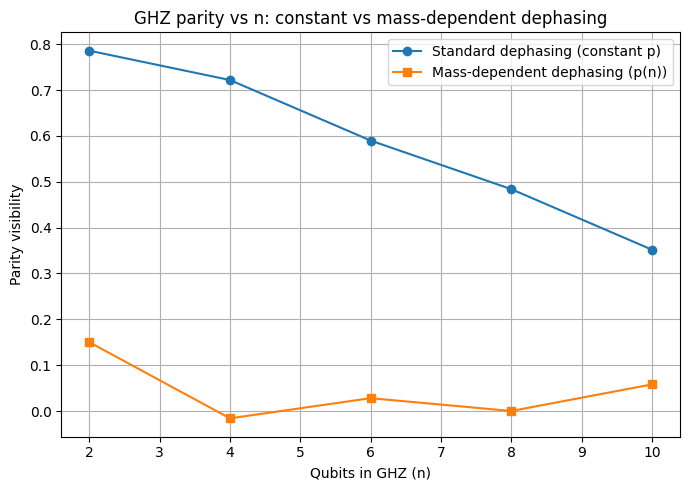

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, phase_damping_error
import numpy as np, math, matplotlib.pyplot as plt

# Simulator
backend = AerSimulator(method="automatic")  # good with noise; lighter than always density_matrix

def mass_dep_dephasing_prob(M, k=0.03, alpha=2.0):
    return 1.0 - math.exp(-k * (M ** alpha))

def noise_model_for_mass(M, k=0.03, alpha=2.0):
    p = mass_dep_dephasing_prob(M, k, alpha)
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(phase_damping_error(p), ['id'])
    return nm

def ghz_circuit(n, time_slices=20):
    qc = QuantumCircuit(n, n)
    qc.h(0)
    for i in range(n-1):
        qc.cx(0, i+1)
    qc.barrier()
    for _ in range(time_slices):
        for q in range(n):
            qc.id(q)     # where phase-damping attaches
    qc.barrier()
    for q in range(n):
        qc.h(q)
    qc.measure(range(n), range(n))
    return qc

def parity_from_counts(counts):
    shots = sum(counts.values())
    parity = 0
    for b, c in counts.items():
        ones = b.count('1')
        parity += c if (ones % 2 == 0) else -c
    return parity / shots

def run_ghz_scaling(n_list, k=0.03, alpha=2.0, time_slices=20, shots=1000, p_const=0.01):
    par_mass, par_const = [], []
    for n in n_list:
        qc = ghz_circuit(n, time_slices=time_slices)

        # Transpile WITHOUT backend so no target width limit, keep 'id's
        tqc = transpile(qc, optimization_level=0, basis_gates=['id','cx','h','measure'])

        # Mass-dependent
        nm_mass = noise_model_for_mass(M=n, k=k, alpha=alpha)
        res = backend.run(tqc, noise_model=nm_mass, shots=shots).result()
        par_mass.append(parity_from_counts(res.get_counts()))

        # Constant dephasing baseline
        nm_const = NoiseModel()
        nm_const.add_all_qubit_quantum_error(phase_damping_error(p_const), ['id'])
        res2 = backend.run(tqc, noise_model=nm_const, shots=shots).result()
        par_const.append(parity_from_counts(res2.get_counts()))
    return np.array(par_mass), np.array(par_const)

# Safer settings for free Colab
n_list = list(range(2, 12, 2))   # <= 10 qubits to keep runtime sane
par_mass, par_const = run_ghz_scaling(n_list, k=0.03, alpha=2.0, time_slices=20, shots=1000)

plt.figure(figsize=(7,5))
plt.plot(n_list, par_const, marker='o', label='Standard dephasing (constant p)')
plt.plot(n_list, par_mass,  marker='s', label='Mass-dependent dephasing (p(n))')
plt.xlabel('Qubits in GHZ (n)'); plt.ylabel('Parity visibility')
plt.title('GHZ parity vs n: constant vs mass-dependent dephasing')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

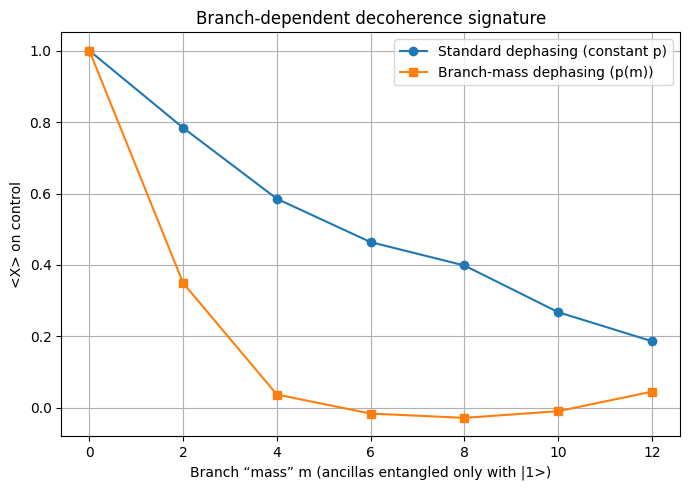

In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, phase_damping_error
import numpy as np, math, matplotlib.pyplot as plt

backend = AerSimulator(method="automatic")

def mass_dep_dephasing_prob(M, k=0.01, alpha=1.0):
    return 1.0 - math.exp(-k * (M ** alpha))

def noise_model_for_mass(M, k=0.01, alpha=1.0):
    nm = NoiseModel()
    p = mass_dep_dephasing_prob(M, k, alpha)
    nm.add_all_qubit_quantum_error(phase_damping_error(p), ['id'])
    return nm

def branch_mass_circuit(m, time_slices=20):
    # 1 control + m ancillas that represent “mass” only in |1> branch
    n = 1 + m
    qc = QuantumCircuit(n, 1)
    qc.h(0)
    for a in range(1, n):      # attach ancillas to |1> branch
        qc.cx(0, a)

    qc.barrier()
    for _ in range(time_slices):
        for a in range(1, n):  # noise only on ancillas (the “mass”)
            qc.id(a)
    qc.barrier()

    for a in range(1, n):      # disentangle so we can read control cleanly
        qc.cx(0, a)
    qc.h(0)                    # measure control in X basis
    qc.measure(0, 0)
    return qc

def x_expect_from_counts(counts):
    shots = sum(counts.values())
    p0 = counts.get('0', 0) / shots
    p1 = counts.get('1', 0) / shots
    return p0 - p1             # <X> = P(0) - P(1)

def run_branch_mass(m_list, k=0.01, alpha=1.0, time_slices=25, shots=2000, p_const=0.01):
    X_mass, X_const = [], []
    for m in m_list:
        qc = branch_mass_circuit(m, time_slices=time_slices)
        tqc = transpile(qc, optimization_level=0, basis_gates=['id','cx','h','measure'])

        # mass-dependent dephasing scales with m (branch mass proxy)
        nm_mass = noise_model_for_mass(M=m, k=k, alpha=alpha)
        res = backend.run(tqc, noise_model=nm_mass, shots=shots).result()
        X_mass.append(x_expect_from_counts(res.get_counts()))

        # constant dephasing baseline
        nm_const = NoiseModel()
        nm_const.add_all_qubit_quantum_error(phase_damping_error(p_const), ['id'])
        res2 = backend.run(tqc, noise_model=nm_const, shots=shots).result()
        X_const.append(x_expect_from_counts(res2.get_counts()))
    return np.array(X_mass), np.array(X_const)

m_list = list(range(0, 13, 2)) # 0..12 ancillas
X_mass, X_const = run_branch_mass(m_list, k=0.02, alpha=1.0, time_slices=25, shots=1500)

plt.figure(figsize=(7,5))
plt.plot(m_list, X_const, marker='o', label='Standard dephasing (constant p)')
plt.plot(m_list, X_mass,  marker='s', label='Branch-mass dephasing (p(m))')
plt.xlabel('Branch “mass” m (ancillas entangled only with |1>)'); plt.ylabel('<X> on control')
plt.title('Branch-dependent decoherence signature')
plt.grid(True); plt.legend(); plt.tight_layout();
plt.savefig('branch_mass_signature.png', dpi=180); plt.show()

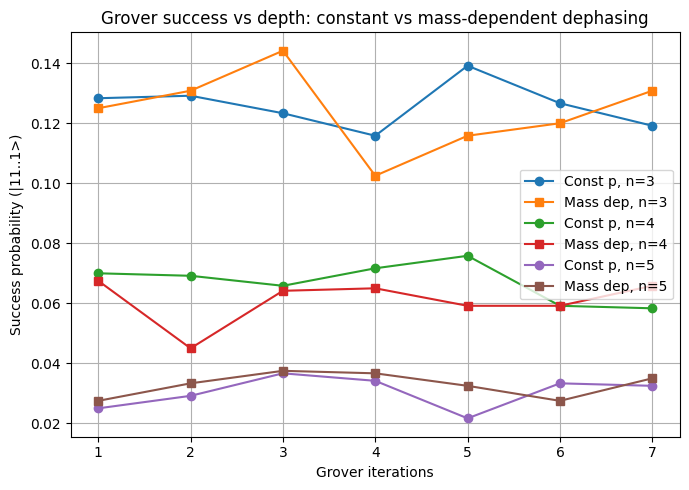

In [6]:
# --- Grover: success vs depth, constant vs mass-dependent dephasing (Colab-ready) ---

!pip -q install qiskit qiskit-aer

import math, numpy as np, matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, phase_damping_error

# ---------- Simulator ----------
backend = AerSimulator(method="automatic")   # good balance for noisy sims

# ---------- Mass-dependent dephasing (Penrose proxy) ----------
def mass_dep_p(M, k=0.0015, alpha=2.0):
    """Collapse-like dephasing probability p(M) = 1 - exp(-k * M^alpha)."""
    return 1.0 - math.exp(-k * (M ** alpha))

def noise_model_mass(M, k=0.0015, alpha=2.0):
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(phase_damping_error(mass_dep_p(M,k,alpha)), ['id'])
    return nm

# ---------- Oracle + Grover iterate ----------
def oracle_all_ones(n: int):
    """Phase-flip |11..1>. Uses mcx then we'll fully decompose it."""
    qc = QuantumCircuit(n, name='Oracle')
    qc.mcx(list(range(n-1)), n-1)  # multi-controlled X on last qubit
    return qc.to_gate()

def grover_circuit(n: int, iters: int = 3):
    """Minimal Grover with an idle slice per iteration to carry dephasing."""
    qc = QuantumCircuit(n, n)
    qc.h(range(n))
    O = oracle_all_ones(n)
    for _ in range(iters):
        qc.append(O, range(n))
        # cheap diffusion around |+>^n (sufficient for our toy benchmark)
        qc.h(range(n)); qc.append(O, range(n)); qc.h(range(n))
        # idle slice where noise model attaches to 'id'
        for q in range(n):
            qc.id(q)
    qc.measure(range(n), range(n))
    # IMPORTANT: fully decompose mcx/ccx/etc before transpile to avoid basis issues
    return qc.decompose(reps=5)

def run_grover(n_list, iters_list, shots=1200, p_const=0.002, k=0.0015, alpha=2.0):
    succ_mass, succ_const = {}, {}
    for n in n_list:
        succ_mass[n], succ_const[n] = [], []
        for it in iters_list:
            qc = grover_circuit(n, iters=it)

            # Transpile WITHOUT backend & with low optimization so 'id' survives
            tqc = transpile(qc, optimization_level=0)

            # Mass-dependent (proxy = n, i.e., register size)
            res = backend.run(tqc, noise_model=noise_model_mass(n,k,alpha), shots=shots).result()
            counts = res.get_counts()
            succ_mass[n].append(counts.get('1'*n, 0)/shots)

            # Constant dephasing baseline (same prob on every qubit per idle-slice)
            nm_const = NoiseModel()
            nm_const.add_all_qubit_quantum_error(phase_damping_error(p_const), ['id'])
            res2 = backend.run(tqc, noise_model=nm_const, shots=shots).result()
            counts2 = res2.get_counts()
            succ_const[n].append(counts2.get('1'*n, 0)/shots)
    return succ_mass, succ_const

# ---------- Run (keep small for free Colab) ----------
n_list     = [3,4,5]                 # small registers
iters_list = list(range(1,8))        # depth sweep
succ_mass, succ_const = run_grover(n_list, iters_list, shots=1200)

# ---------- Plot ----------
plt.figure(figsize=(7,5))
for n in n_list:
    plt.plot(iters_list, succ_const[n], marker='o', label=f'Const p, n={n}')
    plt.plot(iters_list, succ_mass[n],  marker='s', label=f'Mass dep, n={n}')
plt.xlabel('Grover iterations'); plt.ylabel('Success probability (|11..1>)')
plt.title('Grover success vs depth: constant vs mass-dependent dephasing')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig('grover_mass_signature.png', dpi=180)
plt.show()